#Locally adaptive Bayesian covariance regression:
## Making test data

Here, we follow the algorithm given in [Durante, Scarpa, and Dunson (2014)](https://www.researchgate.net/profile/David_Dunson/publication/232063211_Locally_adaptive_factor_processes_for_multivariate_time_series/links/09e4150df41e8d582a000000.pdf).

## Test data set

The description in the paper is a bit sketchy, but we are following Section 4.1.

In [10]:
using PyPlot
using Distributions
using PyCall
plt.style[:use]("ggplot")
srand(12347)

### Set parameters

In [2]:
Np = 5  # dimension of observation 
NL = 2  # Left dimension of \Theta
NK = 2  # Right dimension of \Theta

2

### Make $\xi(t)$

The $\Xi(t)$ matrix is $L \times K$. Each $\xi_{lk}(t), t \in [0, 1]$ is like a "bumps" function from [Donoho and Johnstone (1994)](http://biomet.oxfordjournals.org/content/81/3/425.short).

In [3]:
# bump kernel function
function K_bumps(t::Float64)
    return (1 + abs(t))^-4
end

# make weighted kernel function
function make_curve(nbumps, kern, max_scale, weight_range, tobs)
    kern_locs = sort(rand(nbumps))
    kern_scales = max_scale * rand(nbumps)
    kern_list = [(t -> kern((t - ti) / s)) for (ti, s) in zip(kern_locs, kern_scales)]
    w_min, w_max = weight_range
    weights = w_min + (w_max - w_min) * rand(nbumps)
    K_mat = [f(t) for f in kern_list, t in tobs]
    return weights' * K_mat
end

make_curve (generic function with 1 method)

Sanity check:

(101,)


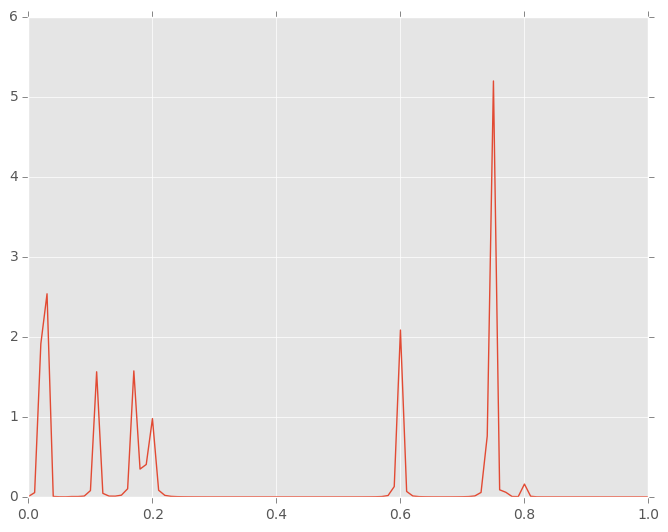

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f165a2a34d0>

In [4]:
tobs = collect(0:0.01:1)  # observation points
Nt = length(tobs)
println(size(tobs))

bumps = make_curve(11, K_bumps, 0.01, (3, 6), tobs)

plot(tobs, bumps')

Now make a matrix of these:

In [5]:
ξ = Array(Float64, Nt, NL, NK)

for l in 1:NL, k in 1:NK
    ξ[:, l, k] = make_curve(11, K_bumps, 0.01, (3, 6), tobs)
end

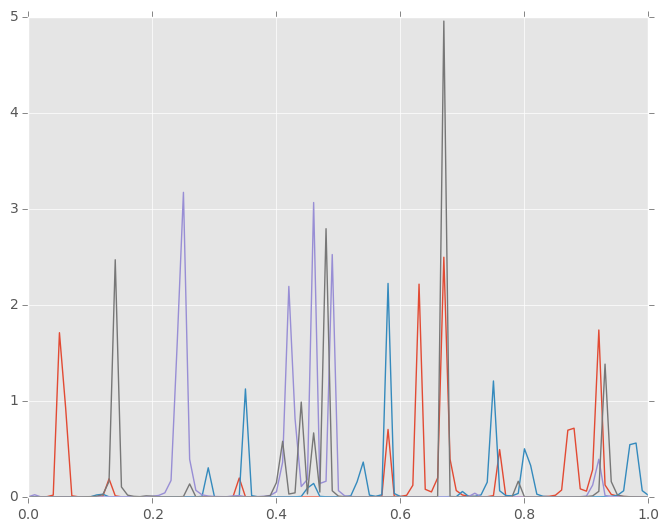

In [6]:
for l in 1:NL, k in 1:NK
    plot(tobs, ξ[:, l, k])
end

### Make $\psi(t)$

The $K$-vector $\Psi(t)$ is the mean of each dictionary element, drawn from a Gaussian process with standard $e^{-|x-x'|^2/\kappa^2}$ kernel.

Unfortunately the distance matrix $D(x, x')$ is very close to singular, so the `MvNormal` sampler will complain. As a hack, we'll just do the SVD:

$$D = U\Lambda U^\top$$

after which we can sample $x \sim \mathcal{N}(0, 1)$ $N_t$ times and 

$$ y = U\Lambda^{\frac{1}{2}} x \sim \mathcal{N}(0, D)$$

In [25]:
# make enormous covariance matrix
κ = 0.1  # is 10 in Durante et al., but we include rescaling by 100

dist_mat = Float64[exp(-(ti - tj)^2/κ^2) for ti in tobs, tj in tobs]
dmat = svd(dist_mat)
A = scale(dmat[1], map(sqrt, dmat[2])) 

ψ = Array(Float64, Nt, NK)

for k in 1:NK
    ψ[:, k] = A * randn(Nt)
end

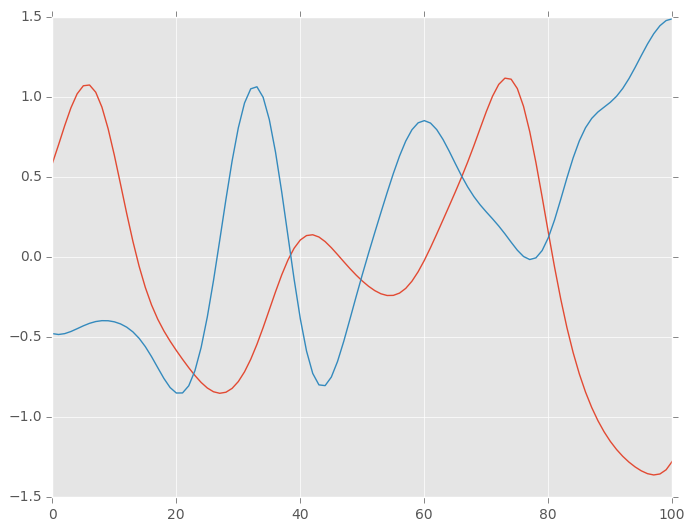

2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1615d15350>
 PyObject <matplotlib.lines.Line2D object at 0x7f1615d155d0>

In [27]:
plot(ψ)

### Make $\Theta$

From Durante et al., we have 

$$\begin{align}
\theta_{jl} &\sim \mathcal{N}(0, \phi_{jl}^{-1} \tau_l^{-1}) \\
\phi_{jl} &\sim \mathrm{Ga}\left(\frac{3}{2}, \frac{3}{2} \right) \\
\tau_l &= \prod_h^l \vartheta_h \\
\vartheta_1 &\sim \mathrm{Ga}(a_1, 1) \\
\vartheta_h &\sim \mathrm{Ga}(a_2, 1) \quad h \ge 2
\end{align}$$

In [59]:
function draw_θ(p, L, a1, a2)
    ϕ = rand(Gamma(3//2, 3//2), p, L)
    th = Array(Float64, L)
    th[1] = rand(Gamma(a1, 1))
    th[2:end] = rand(Gamma(a2, 1), L - 1)
    τ = cumprod(th)
    σ = 1 ./ map(sqrt, (ϕ .* τ'))
    θ = randn(p, L) .* σ
    return θ
end

draw_θ (generic function with 1 method)

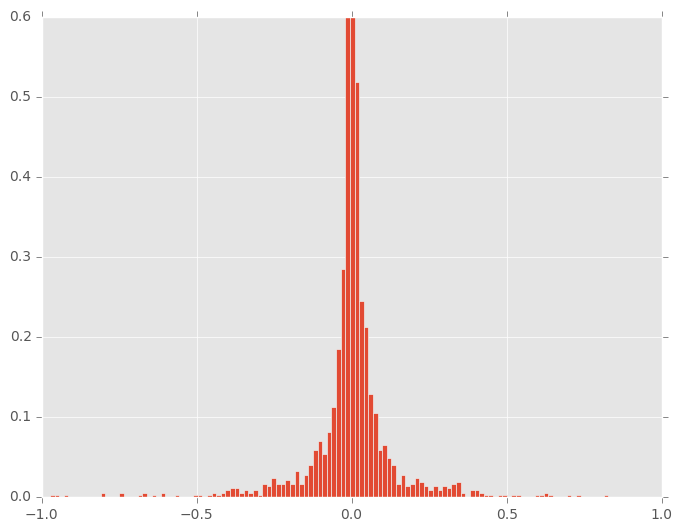

(-1,1)

In [76]:
Theta = draw_θ(500, 50, 10, 10)

plt.hist(Theta[:], 200, normed=true)
plt.ylim(0, 0.6)
plt.xlim(-1, 1)